# Correlations to filter features for propensity score matching

### Import the packages 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import plotly
import plotly.express as px
import scipy
from scipy.stats import spearmanr
import os
import re
import statsmodels.api as sm

### Define the paths of the different datasets use for the analysis
Three main datasets are used for this project:
- **Tesco dataset**: besides the nutrients information used in the validation analysis of the paper, this dataset offers information on the purchases of different products at the area level. It's those information that will be used in our project at the LSOA level. 
- **Socio-economic dataset of the LSOA**: this dataset provides socio-economic information at the LSOA level. Combining this dataset with the Tesco one will allow us to put into perspective the ethnicity of the population with their food consumption. 
- **Geographical information dataset of the LSOA**: this dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

### Define some functions that will be used throughout the project
The roles of the functions define below are the following:
- `load_merge_clean_data()`: this function takes as input the paths of the three datasets used in this project. It will load those different datasets and process them to return one single dataset containing the information of the three datasets of interest.
- `plot_map()`: this function allows to display a feature on the London map with its values assigned to each geographical region representing the LSOA. It takes as input the dataframe considered (that should contain the geographical information) as well as the name of the feature to be plotted on the map, if this feature is part of the dataframe, OR the feature array can directly be given as an input as well. 

In [3]:
###############################################################################################################
#############################     Load merge and clean function      ##########################################
###############################################################################################################
def filter_and_clean_losa(lsoa_df):
    
    filtered_df = lsoa_df.copy()
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
    
    return filtered_df


def load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH):
    '''
    This function load the different datasets used for the analysis,
    clean and merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # load the data with the geography information of each LSOA
    map_df = gpd.read_file(GEO_LSOA_PATH)
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # load the data with the Tesco information of each LSOA
    data_df = pd.read_csv(TESCO_PATH)
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(data_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # load the data with the socio-economic information of each LSOA
    lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    lsoa_df.drop(lsoa_df.tail(2).index,inplace=True)
    # filter the lsoa dataset
    lsoa_df = filter_and_clean_losa(lsoa_df)
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower Super Output Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # remove spaces in column names
    merged_map_lsoa_df.columns = merged_map_lsoa_df.columns.str.replace(' ', '_')
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


###############################################################################################################
#####################################     Plot functions     ##################################################
###############################################################################################################

def plot_map(dataframe, name_feature, color = 'magma', opacity = 0.9):
    '''
    plot the feature of the dataframe on the London map
    '''
    fig = px.choropleth_mapbox(dataframe,
                               geojson=dataframe.geometry,
                               locations=dataframe.index,
                               color=name_feature,
                               center={"lat": 51.49, "lon": -0.127},
                               mapbox_style="carto-positron",
                               opacity = opacity,
                               color_continuous_scale = color, # https://plotly.com/python/colorscales/   
                               # magma, viridis
                               zoom=9)

    fig.update_layout(height = 500, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

### Create the dataframe with all the information of the three datasets of interest

In [4]:
full_df = load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH)
full_df.head(5)


,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.886,0.094,0.020,0.592,0.325,0.061,0.017,0.005,74846.0,58347.0
City of London 001B,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,0.899,0.074,0.027,0.580,0.353,0.046,0.016,0.006,73325.0,57159.0
City of London 001C,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,0.807,0.132,0.062,0.802,0.181,0.013,0.002,0.001,44130.0,34387.0
City of London 001E,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,0.794,0.133,0.073,0.762,0.214,0.019,0.004,0.000,30781.0,24000.0
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.861,0.097,0.042,0.343,0.459,0.160,0.026,0.013,46141.0,39141.0


## Computation of new features

new entropies

In [5]:
def compute_entropies(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)
    
    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h'].values, h_df['h_norm'].values

We then compute an entropy of the diverse ethnic groups in each area to get a sense of the racial diversity of the area

For our entropy computation, we need the representation of each ethnic groups to be described as a probability between 0 and 1 instead of a percentage value, we will modify those columns accordingly in the dataframe

In [6]:
ethnicity_col_list = ['Ethnic_Group;White_(ratio);2011',
                      'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                      'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                      'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                      'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicity, h_ethnicity_norm = compute_entropies(full_df, ethnicity_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicity_norm.tolist(), True)
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities;2011', h_ethnicity.tolist(), True)

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# No more representativity filter

To keep only the most representative areas for our analysis, we filter the dataset by representativity score as described in the Tesco paper

In [7]:
repr_df = full_df.copy()
repr_df.shape

(4833, 284)

In [8]:
def filter_repr( repr_df ):

    lone_rel_col = ['h_items_norm',
                    'Ethnic_Group;h_ethnicities_norm;2011',
                    'Country_of_Birth;ratio_United_Kingdom;2011',
                    'Household_Language;ratio_of_households_with_at_least_one_person_aged_16_or_over_with_English_as_a_main_language;2011']
    out_df = repr_df.loc[:, lone_rel_col]
    
    out_df = pd.concat([ out_df, repr_df.loc[:, 'representativeness_norm':'people_per_sq_km' ] ], axis=1)
    out_df = pd.concat([ out_df, repr_df.loc[:, 'Households;All_households;2011':'Household_Composition;ratio_Other_multi_person_household;2011'] ], axis=1)
    out_df = pd.concat([ out_df, repr_df.loc[:, 'Religion;Christian_(ratio);2011': ] ], axis=1)
    
    # found out the columns are not all numeric
    for col in out_df.columns:
        out_df[col] = pd.to_numeric(out_df[col])
    
    out_df.reset_index(inplace=True)
    out_df.drop(['LSOA11NM'], axis=1, inplace=True)
    out_df.dropna(axis=1, inplace=True)
    
    return out_df
    
filtered_df = filter_repr(repr_df)
print(filtered_df.shape)
filtered_df.sample(5)

(4833, 71)


,h_items_norm,Ethnic_Group;h_ethnicities_norm;2011,Country_of_Birth;ratio_United_Kingdom;2011,Household_Language;ratio_of_households_with_at_least_one_person_aged_16_or_over_with_English_as_a_main_language;2011,representativeness_norm,transaction_days,num_transactions,man_day,population,male,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
1540,0.780097,0.648311,0.671,0.889,0.160411,364.0,71469.0,6169.0,1806.0,855.0,...,0.818,0.132,0.050,0.313,0.460,0.183,0.038,0.006,49976.0,39641.0
1886,0.801423,0.657452,0.604,0.844,0.097191,364.0,39501.0,4598.0,1686.0,807.0,...,0.843,0.107,0.049,0.496,0.389,0.100,0.011,0.003,44711.0,33951.0
1554,0.806996,0.661037,0.698,0.915,0.142240,364.0,56683.0,5258.0,1648.0,792.0,...,0.816,0.125,0.059,0.421,0.449,0.107,0.019,0.005,32659.0,25148.0
4264,0.805584,0.795073,0.433,0.734,0.228895,364.0,181257.0,13517.0,1860.0,913.0,...,0.846,0.111,0.044,0.507,0.385,0.091,0.017,0.000,34721.0,28080.0
4184,0.790317,0.471709,0.579,0.848,0.159879,364.0,104919.0,11035.0,2177.0,1130.0,...,0.897,0.070,0.032,0.526,0.380,0.078,0.011,0.004,92592.0,70068.0


## New entropy features

In [9]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011',
                         'Economic_Activity;Employment_Rate;2011',
                         'Economic_Activity;Unemployment_Rate;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                   'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                   'Health;Day-to-day_activities_not_limited_(ratio);2011',
                   'Health;Very_good_or_Good_health_(ratio);2011',
                   'Health;Fair_health_(ratio);2011',
                   'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']



h_household_compo, h_household_compo_norm = compute_entropies(filtered_df, household_compo_col_list)
h_religion, h_religion_norm = compute_entropies(filtered_df, religion_col_list)
h_tenure, h_tenure_norm = compute_entropies(filtered_df, tenure_col_list)
h_dwelling, h_dwelling_norm = compute_entropies(filtered_df, dwelling_col_list)
h_eco_activity, h_eco_activity_norm = compute_entropies(filtered_df, eco_activity_col_list)
h_qualif, h_qualif_norm = compute_entropies(filtered_df, qualif_col_list)
h_health, h_health_norm = compute_entropies(filtered_df, health_col_list)
h_car_avail, h_car_avail_norm = compute_entropies(filtered_df, car_avail_col_list)
h_age, h_age_norm = compute_entropies(filtered_df, age_col_list)



# insert the new columns
new_h_idx = filtered_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
filtered_df.insert(new_h_idx, 'h_household_compo', h_household_compo.tolist(), True)
filtered_df.insert(new_h_idx, 'h_religion', h_religion.tolist(), True)
filtered_df.insert(new_h_idx, 'h_tenure', h_tenure.tolist(), True)
filtered_df.insert(new_h_idx, 'h_dwelling', h_dwelling.tolist(), True)
filtered_df.insert(new_h_idx, 'h_eco_activity', h_eco_activity.tolist(), True)
filtered_df.insert(new_h_idx, 'h_qualif', h_qualif.tolist(), True)
filtered_df.insert(new_h_idx, 'h_health', h_health.tolist(), True)
filtered_df.insert(new_h_idx, 'h_car_avail', h_car_avail.tolist(), True)
filtered_df.insert(new_h_idx, 'h_age', h_age.tolist(), True)


filtered_df.shape

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 80)

In [10]:
to_remove = ['Household_Composition;',
             'Household_Language;',
             'Religion;',
             'Tenure;',
             'Dwelling_type;',
             'Economic_Activity;',
             'Qualifications;',
             'Health;', 
             'Car_or_van_availability;', 
             'transaction_days']

to_drop = []
for col in filtered_df.columns:
    for sub in to_remove:
        if(sub in col):
            to_drop.append(col)
filtered_df.drop(to_drop, axis=1, inplace=True)

filtered_df

,h_items_norm,Ethnic_Group;h_ethnicities_norm;2011,h_age,h_car_avail,h_health,h_qualif,h_eco_activity,h_dwelling,h_tenure,h_religion,...,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,Households;All_households;2011,House_Prices;Sales;2011,Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
0,0.754474,0.374122,-11646.622524,1.359020,1.188623,1.457848,-8940.659191,0.663183,1.723821,1.843880,...,766.0,351.0,48.293981,0.13,9985.0,876.0,36.0,0.01,74846.0,58347.0
1,0.760816,0.284661,-10137.780040,1.330185,1.118762,1.389507,-8610.632447,0.851429,1.779799,1.682463,...,656.0,303.0,47.398789,0.23,5061.0,830.0,61.0,0.01,73325.0,57159.0
2,0.794262,0.474398,-12311.450495,0.810979,1.785965,2.306890,-7304.503146,0.428110,1.933214,1.984651,...,850.0,348.0,48.360741,0.06,22843.0,817.0,33.0,0.02,44130.0,34387.0
3,0.781864,0.772516,-9856.540643,0.915315,1.816456,2.708294,-4555.672793,0.559375,1.292671,2.123538,...,675.0,152.0,35.611954,0.19,5912.0,467.0,15.0,0.03,30781.0,24000.0
4,0.780443,0.722766,-19963.757684,1.686517,1.348590,2.851477,-7651.094062,1.817965,1.720078,2.163290,...,1317.0,160.0,32.080392,0.15,13915.0,543.0,10.0,0.06,46141.0,39141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0.813316,0.792895,-16434.822490,1.419629,0.901447,2.504007,-7764.043091,1.247061,1.469892,1.886230,...,1241.0,125.0,33.250441,0.13,13532.0,581.0,11.0,0.05,48387.0,37255.0
4829,0.802985,0.678873,-24527.214560,1.544247,1.045708,2.745867,-8393.921297,2.050771,1.708101,1.378371,...,1494.0,88.0,29.259275,1.00,2423.0,663.0,2.0,0.13,39272.0,30237.0
4830,0.812829,0.739840,-18425.893865,1.461906,1.686487,2.820737,-7974.234176,1.899808,1.816035,1.878410,...,1220.0,131.0,31.960526,0.15,12952.0,646.0,10.0,0.11,35936.0,27670.0
4831,0.794639,0.695822,-19140.548296,1.617273,1.107492,2.757173,-7830.890552,1.710703,1.773152,1.586117,...,1202.0,72.0,30.143296,0.56,3465.0,591.0,4.0,0.14,40849.0,31450.0


## Renaming the columns to make them easier to manipulate

In [11]:
filtered_df = filtered_df.rename(columns={ \
    'Ethnic_Group;h_ethnicities_norm;2011': 'h_ethnic', 
    'Country_of_Birth;ratio_United_Kingdom;2011': 'born_UK',
    'Households;All_households;2011': 'num_households',
    'House_Prices;Sales;2011': 'house_price_sales', 
    'Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011': \
                'households_no_adult_employed',
    'Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)': 'mean_household_income',
    'Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)': 'median_household_income'})

In [12]:
# standardization

std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

,h_items_norm,h_ethnic,h_age,h_car_avail,h_health,h_qualif,h_eco_activity,h_dwelling,h_tenure,h_religion,...,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,num_households,house_price_sales,households_no_adult_employed,mean_household_income,median_household_income
2740,0.544549,-0.289833,0.389569,-0.911768,0.846482,-0.947829,-0.400338,-0.204288,1.071977,0.280744,...,-0.016174,-0.398528,0.122581,-0.342234,0.666201,0.339974,0.263913,-0.196587,0.608951,0.395227
137,0.778304,1.117273,-1.347058,-0.705377,-0.554252,0.633431,-1.832848,-0.041400,0.027452,0.649023,...,1.614056,-0.978118,-0.967697,0.071211,-0.608142,1.410325,-0.349673,0.571070,-0.833504,-0.896233
25,0.878900,0.528406,0.490167,0.086338,1.683336,0.608529,1.474227,0.676501,-0.190061,-0.290863,...,-0.858838,-0.048359,-0.628161,-0.294529,0.175106,-0.475888,-0.886561,1.850498,-0.951665,-0.824432
1561,-0.308575,-0.810319,0.929672,0.094684,1.334162,-0.979089,0.845223,-0.017526,0.958493,-0.974907,...,-1.007925,1.412690,1.885866,-0.183217,-0.508897,0.055545,0.110517,-0.196587,0.586115,0.617349
11,1.409557,-0.179021,0.165364,-0.014247,1.243388,0.396106,0.808218,0.345886,0.858181,-1.098646,...,-0.353240,-0.108733,-0.277878,-0.183217,-0.265462,-0.191459,-0.503070,1.338727,-0.837984,-0.693393


In [14]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
correl_df['feature'] = std_df.columns[1:]

for i, col in enumerate(std_df.columns[1:]):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

,feature,correlation,p_value
0,h_ethnic,0.368818,1.285898e-155
1,h_age,-0.128821,2.454531e-19
2,h_car_avail,-0.304450,3.426849e-104
3,h_health,0.230155,3.993810e-59
4,h_qualif,0.239443,5.517600e-64


In [15]:
alpha = 0.05
filtered_correl_df = correl_df[ correl_df['p_value'] < alpha ]

filtered_correl_df.shape

(27, 3)

In [16]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
filtered_correl_df.head()

,feature,correlation,abs_correlation,p_value
0,h_ethnic,0.368818,0.368818,1.285898e-155
1,h_age,-0.128821,0.128821,2.454531e-19
2,h_car_avail,-0.304450,0.304450,3.426849e-104
3,h_health,0.230155,0.230155,3.993810e-59
4,h_qualif,0.239443,0.239443,5.517600e-64


In [17]:
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(15)

,feature,correlation,abs_correlation,p_value
25,households_no_adult_employed,0.402207,0.402207,2.178904e-187
9,h_household_compo,0.369545,0.369545,2.856378e-156
0,h_ethnic,0.368818,0.368818,1.285898e-155
26,mean_household_income,-0.352765,0.352765,1.258317e-141
27,median_household_income,-0.351866,0.351866,7.241041e-141
12,num_transactions,0.325566,0.325566,1.023985e-119
19,age_65+,-0.312683,0.312683,4.282938e-110
2,h_car_avail,-0.304450,0.304450,3.426849e-104
20,avg_age,-0.303901,0.303901,8.340947e-104
13,man_day,0.303739,0.303739,1.084607e-103


Let's keep the top N features for the General Propensity Score computation.

In [18]:
main_features = sorted_correl_df.head(10)['feature'].tolist()
main_features.append('h_items_norm')
features_df = std_df[main_features]
features_df.columns

Index(['households_no_adult_employed', 'h_household_compo', 'h_ethnic',
       'mean_household_income', 'median_household_income', 'num_transactions',
       'age_65+', 'h_car_avail', 'avg_age', 'man_day', 'h_items_norm'],
      dtype='object')

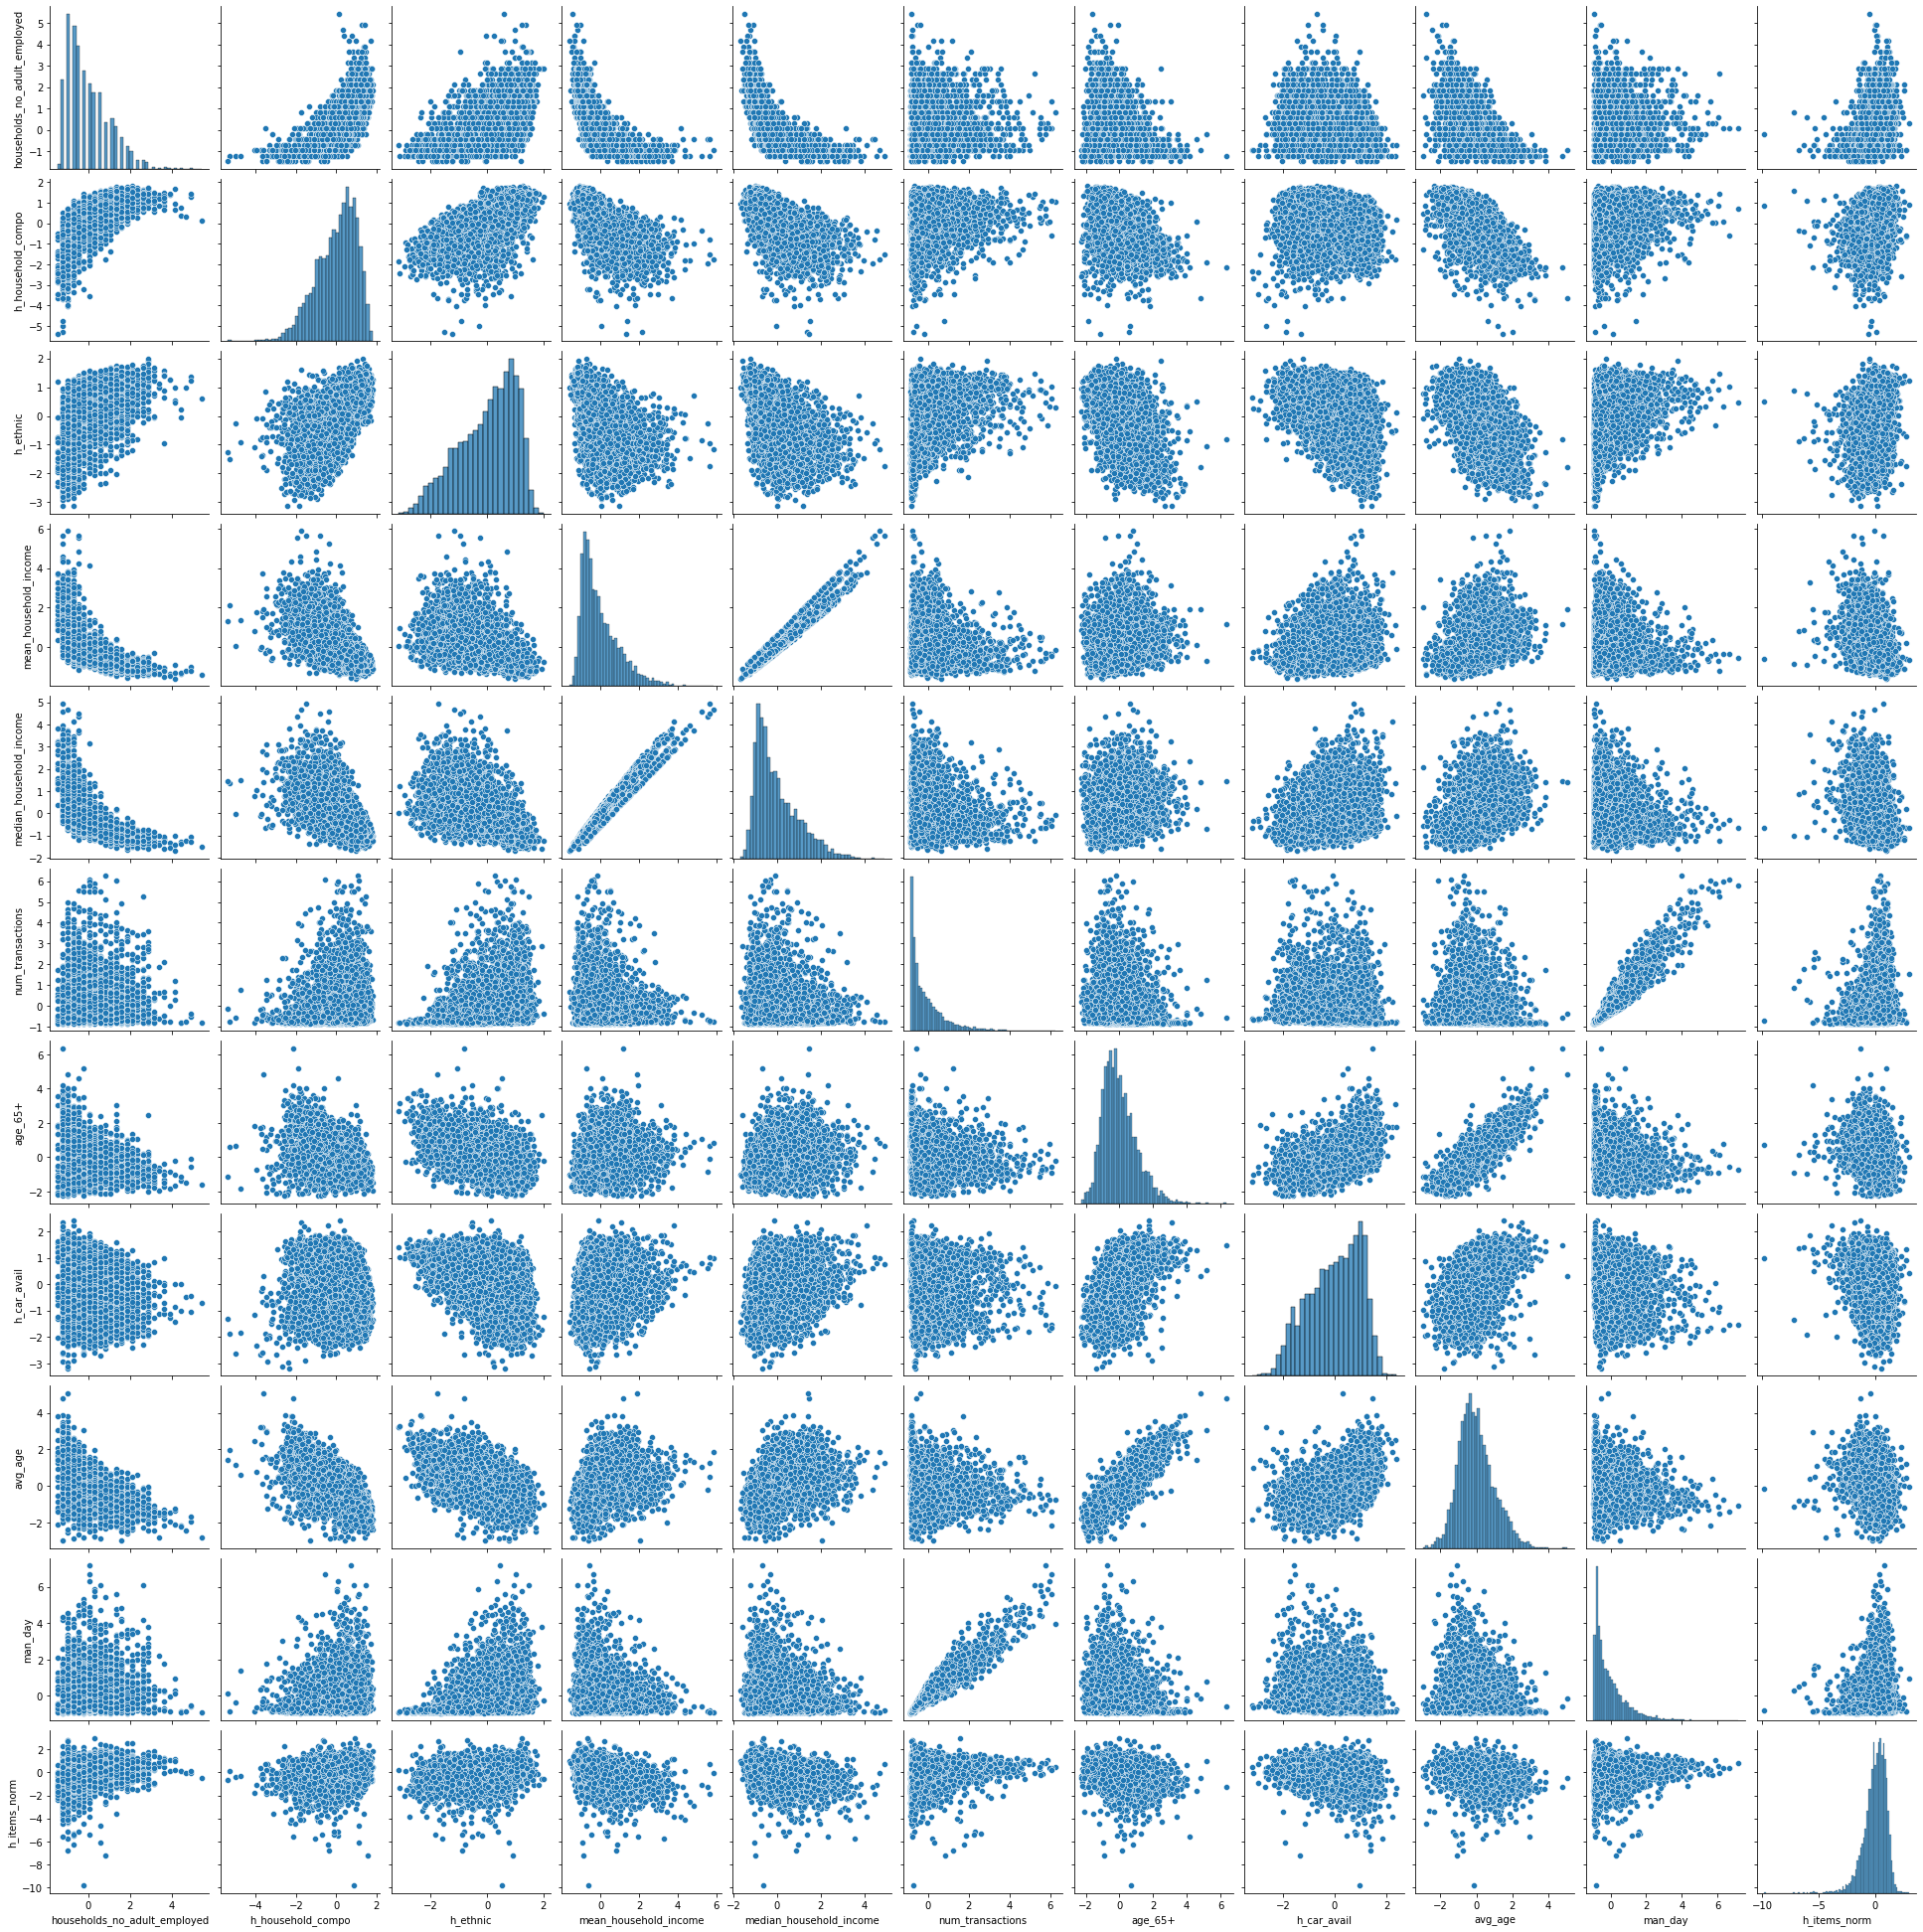

In [19]:
sns.pairplot(features_df)

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

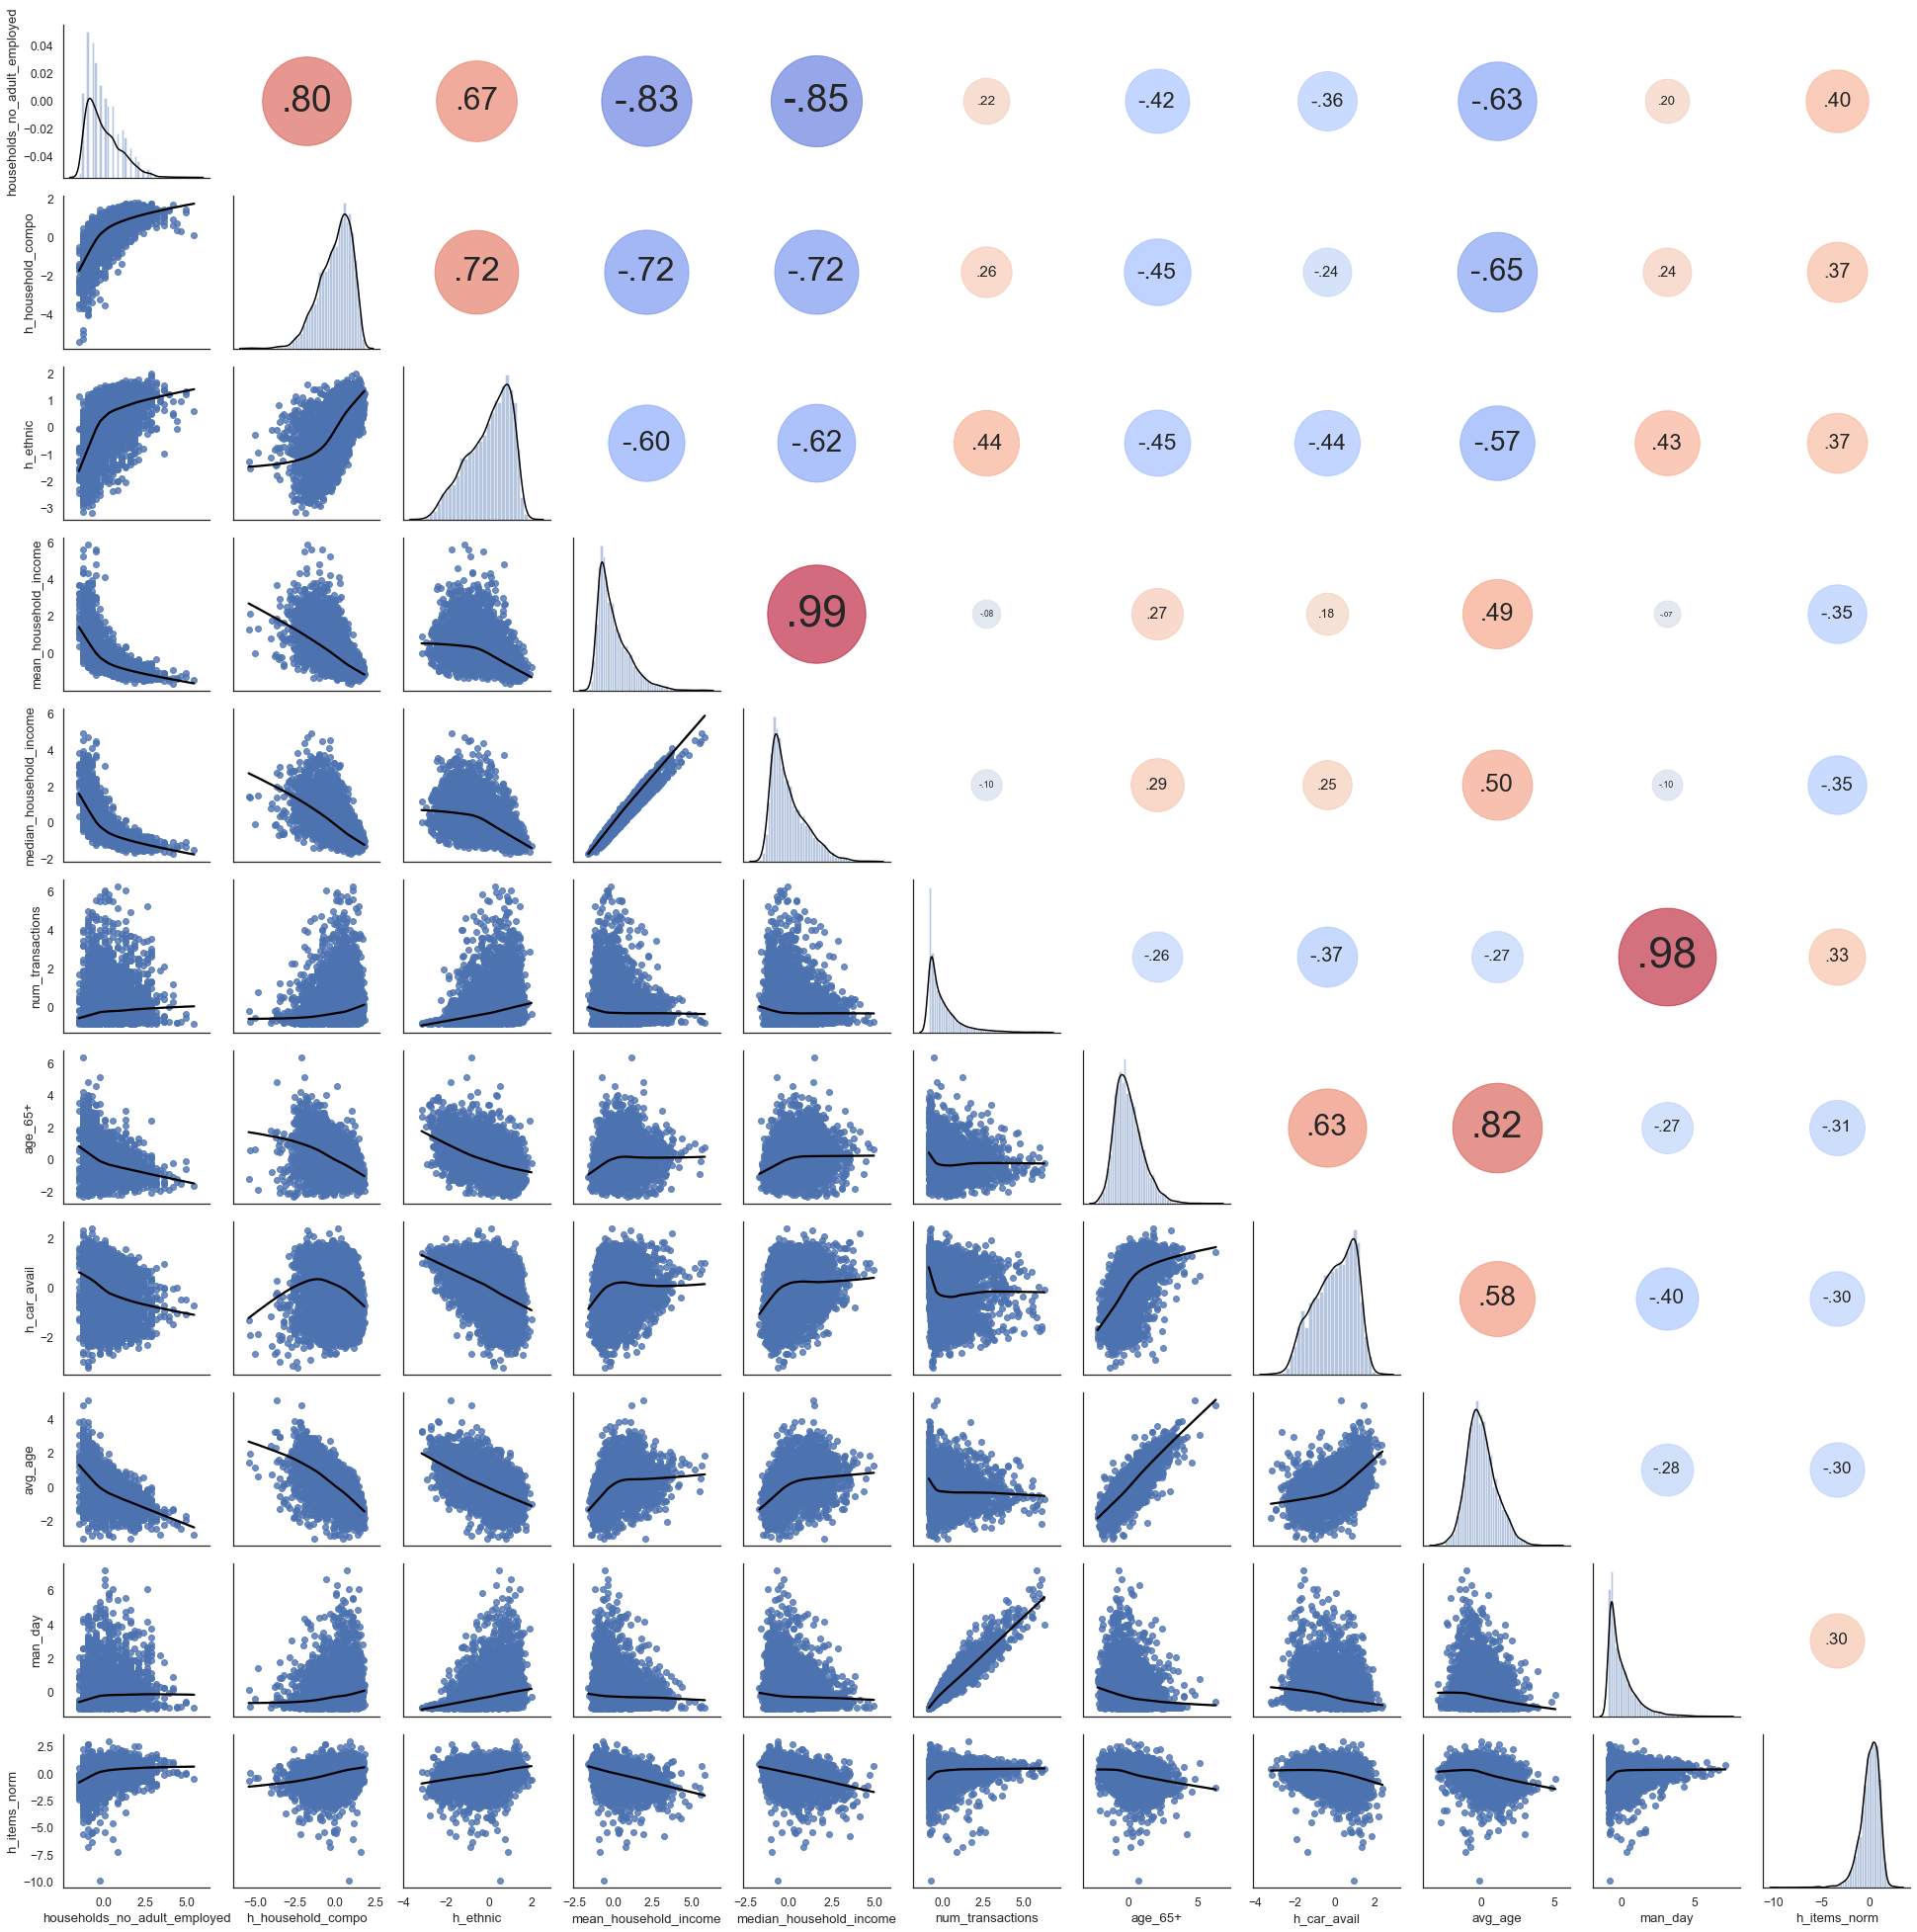

In [20]:
# source: https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.1)
#iris = sns.load_dataset('iris')
g = sns.PairGrid(features_df, aspect=1, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

We can remove the median or the mean income as these two features are very correlated, and same thing for the man day and number of transactions. Let us remove the mean, as the median is by definition a feature more robust to outliers, and the man day.

In [21]:
features_df.drop('mean_household_income', axis=1, inplace=True)
features_df.drop('man_day', axis=1, inplace=True)

features_df

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,households_no_adult_employed,h_household_compo,h_ethnic,median_household_income,num_transactions,age_65+,h_car_avail,avg_age,h_items_norm
0,-1.220129,-3.671440,-1.378314,1.970926,-0.128552,1.738710,-0.660825,3.214487,-1.382303
1,-1.220129,-3.449703,-1.896008,1.867282,-0.407355,1.159120,-0.765959,2.976126,-1.104587
2,-0.964243,-3.757331,-0.798033,-0.119420,-0.195677,1.702485,-2.659005,3.232263,0.359874
3,-0.708358,-0.546058,0.927135,-1.025615,0.760045,-0.664173,-2.278593,-0.162335,-0.182958
4,0.059299,0.685251,0.639235,0.295334,-0.391745,-0.567575,0.533243,-1.102678,-0.245202
...,...,...,...,...,...,...,...,...,...
4828,-0.196587,0.500422,1.045062,0.130793,0.464183,-0.990193,-0.439843,-0.791131,1.194191
4829,1.850498,1.682037,0.385238,-0.481479,-0.186725,-1.436960,0.014517,-1.853852,0.741821
4830,1.338727,1.222995,0.738041,-0.705432,0.626495,-0.917744,-0.285698,-1.134595,1.172886
4831,2.106383,1.229404,0.483319,-0.375653,-0.412268,-1.630156,0.280777,-1.618465,0.376392


In [22]:
from causal_curve import GPS

In [23]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.01,
          upper_grid_constraint=0.99,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
features.remove('h_ethnic')

# Fits the causal dose-response model.
gps.fit(T = features_df['h_ethnic'], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

In [24]:
gps_results = gps.calculate_CDRC(0.95)
gps_results.head()

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI
0,-2.415,-0.959,-1.303,-0.614
1,-2.241,-0.892,-1.220,-0.564
2,-2.121,-0.847,-1.158,-0.537
3,-1.993,-0.794,-1.090,-0.498
4,-1.902,-0.750,-1.040,-0.461


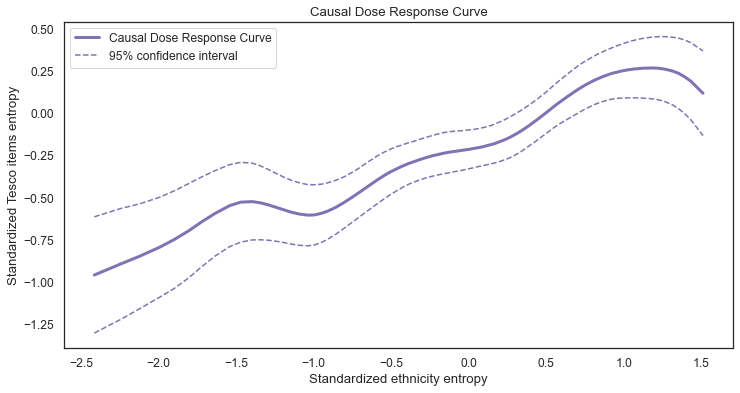

In [25]:
#### THE RESULTS CHANGE A LOT DEPENDING ON THE NUMBER OF SPLINES ###

fig, ax = plt.subplots(figsize=(12,6))
#plt.scatter(h_ethnicity_stand, stand_df['h_items'], s=1, zorder=1)
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
#plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve') # estimated average dose response function ?
plt.xlabel('Standardized ethnicity entropy')
plt.ylabel('Standardized Tesco items entropy')
plt.show()

To measure the significance of the effect of ethnic entropy on items entropy, we can use the following metric: the difference between the minimum value of the upper confidence interval (CI) and the maximum value of the lower CI. Indeed, if this difference is positive, it means that a horizontal line can be drawn inside the 95% confidence interval, which in turn means that the effect of the treatment is not significative (a horizontal line corresponds to  the treatment having no effect on the response of the items entropy).

In [26]:
treatment_effect_metric = (gps_results['Upper_CI'].min() - gps_results['Lower_CI'].max())
print(treatment_effect_metric)

-0.705


The more negative this metric is, the more significative is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe.